<a href="https://colab.research.google.com/github/imraunav/Universal-function-approximators/blob/main/deeplearning_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural networks are universal function approximators
This notebook is a collection of my experiments to see if a neural network can approximate a $sine$ function.

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader

In [2]:
from tqdm import tqdm

In [3]:
x = torch.linspace(0, 1, steps=1000)
y = torch.sin(4*np.pi*x)

In [4]:
def plot(x, y, label, ptype='plot'):
  if ptype=='plot':
    plt.plot(x,y, label=label)
  else:
    plt.scatter(x, y, label=label, c='green', marker='x', alpha=0.3)
  plt.legend()
  plt.xlabel('Input')
  plt.ylabel('Target')

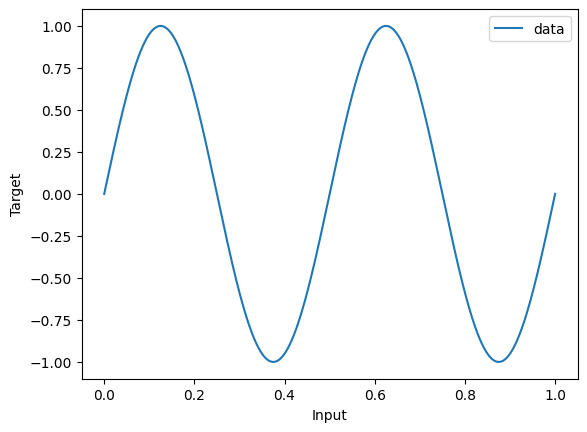

In [5]:
plot(x, y, 'data')

## Training loop

In [6]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=10_000):
    patience = 0
    # Set model to train mode
    # model = model.to(device)
    model.train()

    # Training loop
    loss_per_epoch = []
    for epoch in tqdm(range(num_epochs)):
        # print(f"Epoch: {epoch+1}/{num_epochs} ")
        running_loss = 0
        samples_per_batch = 0
        for data_inputs, data_labels in data_loader:

            # Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            # data_labels = data_labels.type(int)
            data_labels = data_labels.to(device)

            # Step 2: Run the model on the input data
            preds = model(data_inputs)

            # Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)
            # loss_per_update.append(loss)

            # Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 5: Update the parameters
            optimizer.step()
            running_loss += loss.item()
            samples_per_batch += 1
        loss_per_epoch.append(running_loss/samples_per_batch)
        if epoch > 500:
            if abs(loss_per_epoch[-1] - loss_per_epoch[-2]) <= 1e-2:
                patience += 1
            else:
                patience = 0
        if patience > 10:
            break
    return loss_per_epoch

## Creating random sampling to make train-set

In [7]:
class MyDataset(Dataset):
  def __init__(self):
    self.x = torch.rand((500, 1))
    self.y = torch.sin(4*np.pi*self.x)+torch.normal(0, 0.1, size=self.x.shape)
  def __len__(self):
    return len(self.x)
  def __getitem__(self, idx):
    sample = self.x[idx], self.y[idx]
    return sample

In [8]:
x_dataset = MyDataset()
x_dataloader = DataLoader(x_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

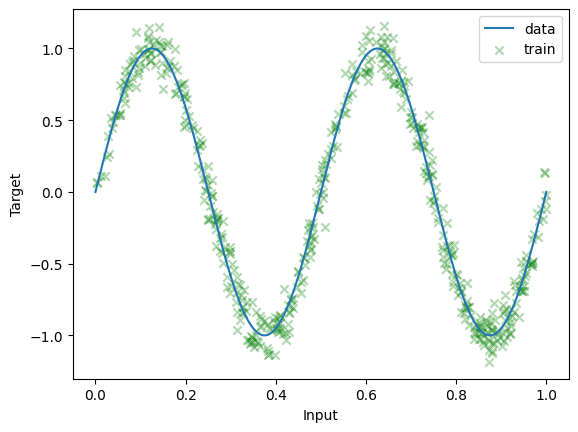

In [9]:
plot(x,y, 'data')
plot(x_dataset.x, x_dataset.y, 'train', 'scatter')

# Define model

In [10]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.h1 = nn.Linear(1, 2)
    self.h2 = nn.Linear(2, 2)
    self.out = nn.Linear(2, 1)
  def forward(self, x):
    x = self.h1(x)
    x = F.leaky_relu(x)
    x = self.h2(x)
    x = F.leaky_relu(x)
    x = self.out(x)
    return x

In [11]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (h1): Linear(in_features=1, out_features=2, bias=True)
  (h2): Linear(in_features=2, out_features=2, bias=True)
  (out): Linear(in_features=2, out_features=1, bias=True)
)


In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [13]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss = nn.MSELoss()

In [14]:
log = train_model(model, optimizer, x_dataloader, loss)

  5%|▌         | 511/10000 [00:23<07:07, 22.18it/s]


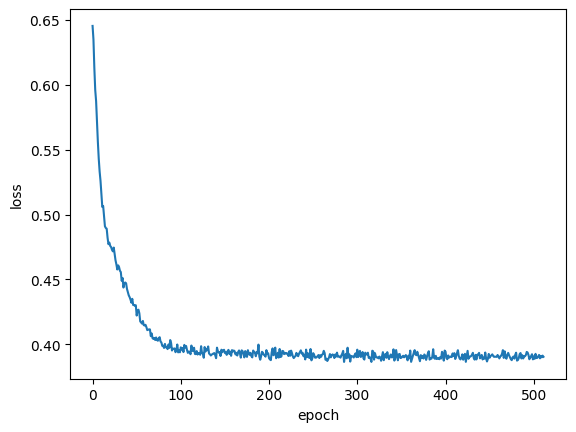

In [15]:
plt.plot(log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [16]:
new_x = torch.linspace(0, 1, 1000)
new_x = new_x.reshape(-1, 1)

In [17]:
new_y = model(new_x.to(device)).to('cpu')

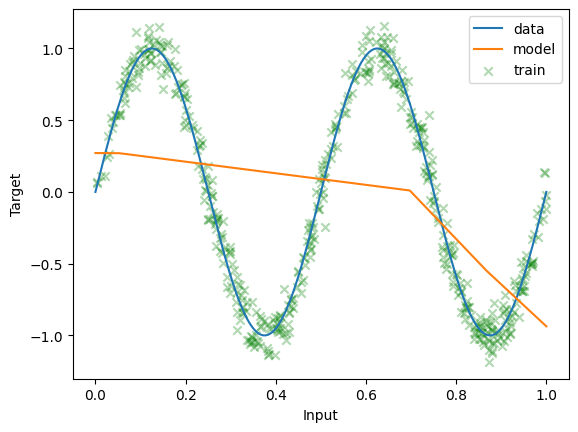

In [18]:
new_y = new_y.reshape(-1).detach()
new_x = new_x.reshape(-1)

plot(x,y, 'data')
plot(new_x, new_y, 'model')
plot(x_dataset.x, x_dataset.y, 'train', 'scatter')

- Too much oscillation, loss as a function of parameters may not be very smooth.
- Not a good approximator.
- Model too simple.

# Model 2
- Adding more neurons per layers
- Using ```Leaky ReLU``` to get better grads.

In [19]:
class NeuralNetwork2(nn.Module):
  def __init__(self):
    super().__init__()
    self.h1 = nn.Linear(1, 3)
    self.h2 = nn.Linear(3, 2)
    self.out = nn.Linear(2, 1)
  def forward(self, x):
    x = self.h1(x)
    x = F.leaky_relu(x)
    x = self.h2(x)
    x = F.leaky_relu(x)
    x = self.out(x)
    return x

In [20]:
model2 = NeuralNetwork2()
model2 = model2.to(device)

In [21]:
optimizer = torch.optim.Adam(model2.parameters())
loss = nn.MSELoss()

In [22]:
log = train_model(model2, optimizer, x_dataloader, loss)

  5%|▌         | 511/10000 [00:14<04:28, 35.34it/s]


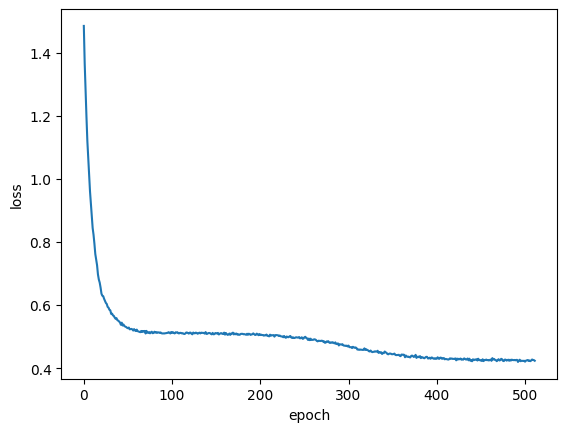

In [23]:
plt.plot(log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [24]:
new_x.shape

torch.Size([1000])

In [25]:
new_x = new_x.reshape(-1, 1)

In [26]:
new_y = model2(new_x.to(device)).to('cpu')

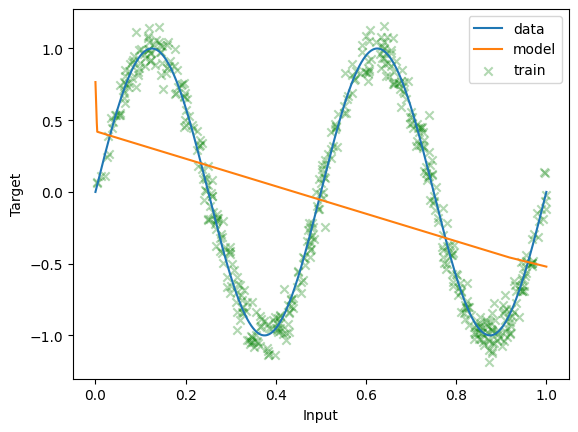

In [27]:
new_y = new_y.reshape(-1).detach()
new_x = new_x.reshape(-1)

plot(x,y, 'data')
plot(new_x, new_y, 'model')
plot(x_dataset.x, x_dataset.y, 'train', 'scatter')

- Model again too simple but gets it somewhat right.

# Model 3
- Increasing units per layers
- using ```Tanh``` activation in the hidden layers.

In [28]:
class NeuralNetwork3(nn.Module):
  def __init__(self):
    super().__init__()
    self.h1 = nn.Linear(1, 10)
    self.h2 = nn.Linear(10, 5)
    self.out = nn.Linear(5, 1)
  def forward(self, x):
    x = self.h1(x)
    x = F.tanh(x)
    x = self.h2(x)
    x = F.tanh(x)
    x = self.out(x)
    return x

In [29]:
model3 = NeuralNetwork3()
model3 = model3.to(device)

In [30]:
optimizer = torch.optim.Adam(model3.parameters())
loss = nn.MSELoss()

In [31]:
log = train_model(model3, optimizer, x_dataloader, loss)

  5%|▌         | 511/10000 [00:14<04:30, 35.05it/s]


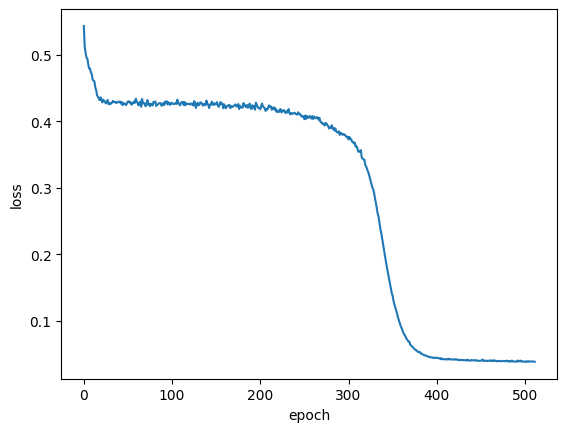

In [32]:
plt.plot(log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [33]:
new_x = new_x.reshape(-1, 1)
new_y = model3(new_x.to(device)).to('cpu')

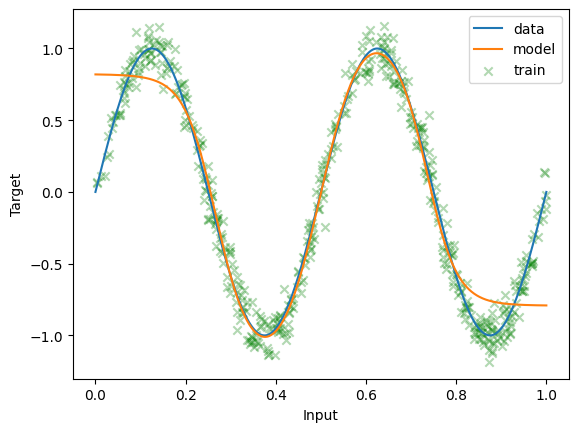

In [34]:
new_y = new_y.reshape(-1).detach()
new_x = new_x.reshape(-1)

plot(x,y, 'data')
plot(new_x, new_y, 'model')
plot(x_dataset.x, x_dataset.y, 'train', 'scatter')


- This works nicely

# Model 4
- Adding more units per layer to see the results.

In [35]:
class NeuralNetwork4(nn.Module):
  def __init__(self):
    super().__init__()
    self.h1 = nn.Linear(1, 25)
    self.h2 = nn.Linear(25, 150)
    self.out = nn.Linear(150, 1)
  def forward(self, x):
    x = self.h1(x)
    x = F.relu(x)
    x = self.h2(x)
    x = F.relu(x)
    x = self.out(x)
    return x

In [36]:
model4 = NeuralNetwork4()
model4 = model4.to(device)

In [37]:
optimizer = torch.optim.Adam(model4.parameters())
loss = nn.MSELoss()

In [38]:
log = train_model(model4, optimizer, x_dataloader, loss)


  5%|▌         | 511/10000 [00:14<04:33, 34.64it/s]


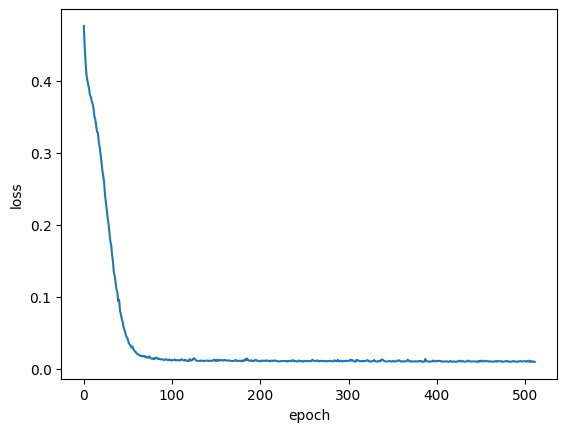

In [39]:
plt.plot(log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [40]:
new_x = new_x.reshape(-1, 1)
new_y = model4(new_x.to(device)).to('cpu')

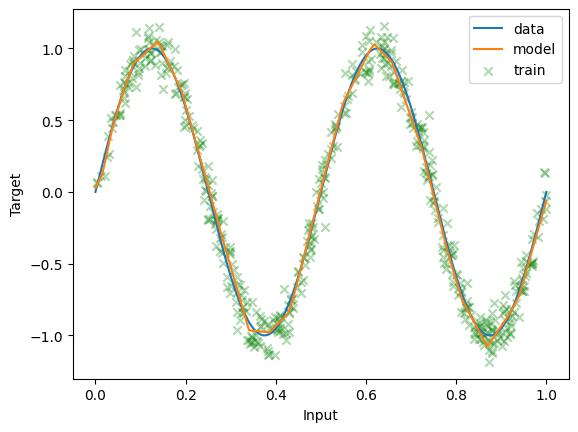

In [41]:
new_y = new_y.reshape(-1).detach()
new_x = new_x.reshape(-1)

plot(x,y, 'data')
plot(new_x, new_y, 'model')
plot(x_dataset.x, x_dataset.y, 'train', 'scatter')

- Does perform good

# Model 5
- Adding more layers to make the model deeper
- Using ```Leaky ReLU``` to get good grads in the deeper network.

In [42]:
class NeuralNetwork5(nn.Module):
  def __init__(self):
    super().__init__()
    self.h1 = nn.Linear(1, 32)
    self.h2 = nn.Linear(32, 64)
    self.h3 = nn.Linear(64, 64)
    self.out = nn.Linear(64, 1)
  def forward(self, x):
    x = self.h1(x)
    x = F.leaky_relu(x)
    x = self.h2(x)
    x = F.leaky_relu(x)
    x = self.h3(x)
    x = F.leaky_relu(x)
    x = self.out(x)
    return x

In [43]:
model5 = NeuralNetwork5().to(device)

In [44]:
optimizer = torch.optim.Adam(model5.parameters())
loss = nn.MSELoss()

In [45]:
log = train_model(model5, optimizer, x_dataloader, loss)

  5%|▌         | 511/10000 [00:16<05:10, 30.53it/s]


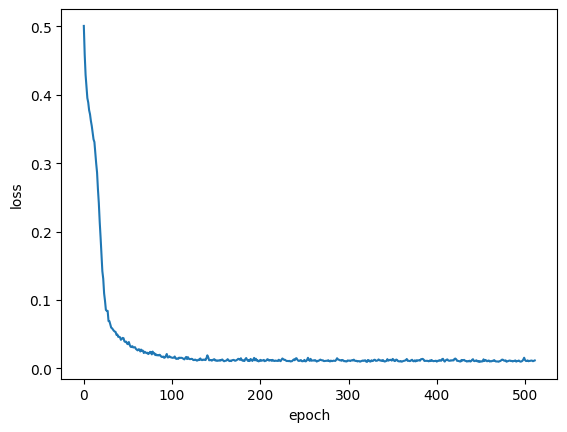

In [46]:
plt.plot(log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [47]:
new_x = new_x.reshape(-1, 1)
new_y = model5(new_x.to(device)).to('cpu')

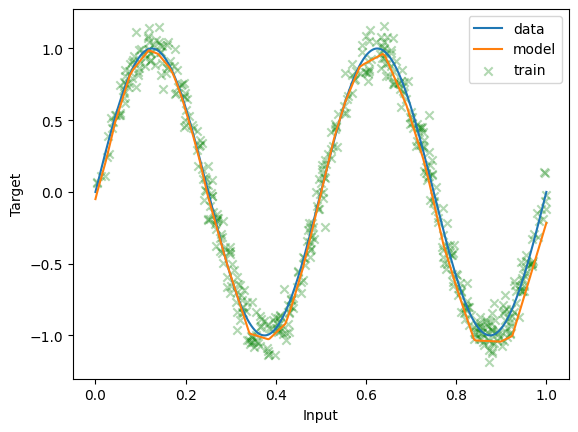

In [48]:
new_y = new_y.reshape(-1).detach()
new_x = new_x.reshape(-1)

plot(x,y, 'data')
plot(new_x, new_y, 'model')
plot(x_dataset.x, x_dataset.y, 'train', 'scatter')

## Inferences
- `Models 4, 5 and 6` showed good potential.
- `Model 4` could approximate well with more epochs, or overtraining.
- The input needs to be normalized. This is a very important learning factor for neural networks.